### 01-NASA Near-Earth Objects (NEOs) Kinetic Energy Prediction

#### **Index**
    -> Dataset Selection
    -> Algorithm Implementation
    -> Evaluation
    -> Deliverables
---

### **1. Dataset Selection**

For this regression experiment, we are using the **NASA Close Approach dataset (2023–2024)**, which provides detailed information about near-Earth objects (NEOs), including asteroids and comets, that have made close approaches to Earth between January 1, 2023, and September 25, 2024. The dataset is sourced from **NASA's Jet Propulsion Laboratory (JPL)** and includes critical parameters like approach distances, velocities, object sizes, and other orbital properties(Pinuto, G., 2024).

---

**Dataset Features**:
- `des`: Object designation (unique identifier for the object)
- `orbit_id`: Orbit identification for close approach
- `jd`: Julian Date for the close approach
- `cd`: Calendar Date for the close approach
- `dist`: Nominal approach distance (AU)
- `dist_min`: Minimum approach distance (AU)
- `dist_max`: Maximum approach distance (AU)
- `v_rel`: Relative velocity at closest approach (km/s)
- `v_inf`: Velocity relative to a massless object (km/s)
- `t_sigma_f`: Time uncertainty for close approach
- `h`: Absolute magnitude of the object

---

**- Target Variable**: 

The kinetic energy (KE) at closest approach, derived from object mass and relative velocity.

**- Number of Records**: 

The dataset contains over **2000+ records** and more than **10 numerical features**.

**- Dataset Source**:  
NASA Close Approach Data 2023–2024. Available at: [https://www.kaggle.com/datasets/pinuto/nasa-close-approach-data-2023-2024](https://www.kaggle.com/datasets/pinuto/nasa-close-approach-data-2023-2024)

---

In [1]:
# Importing the pandas library to facilitate robust data manipulation.

import pandas as pd

# Step 1.1: # Loading the NASA Close Approach dataset from a local CSV file.
# -------------------------------
# This dataset encompasses detailed observational records of near-Earth objects (NEOs)
# spanning from January 2023 to September 2024, and serves as the foundation for 
# predicting the kinetic energy of asteroids and comets during their closest approach.

df = pd.read_csv("nasa_close_approach_2023_2024.csv")  # file path

# Step 1.2: Displays the first few rows of the dataset to conduct an initial inspection.
# -------------------------------
# This provides insight into the structure of the data, feature types, and potential anomalies.

df.head()


,des,orbit_id,jd,cd,dist,dist_min,dist_max,v_rel,v_inf,t_sigma_f,h
0,2022 YS6,6,2.459946e+06,2023-Jan-01 01:15,0.011943,0.011913,0.011973,9.719379,9.696398,< 00:01,26.86
1,2022 YR1,8,2.459946e+06,2023-Jan-01 20:45,0.041749,0.041365,0.042133,6.034629,6.024044,< 00:01,26.04
2,2022 YT3,8,2.459947e+06,2023-Jan-02 00:43,0.028460,0.028384,0.028536,6.438394,6.423836,< 00:01,25.81
3,2022 YU3,5,2.459947e+06,2023-Jan-02 05:11,0.025191,0.025017,0.025365,7.133786,7.118944,< 00:01,25.86
4,2022 YY6,4,2.459947e+06,2023-Jan-02 11:07,0.005439,0.005411,0.005467,20.269551,20.245368,< 00:01,26.15


### **2. Algorithm Implementation:**

**- Regression Algorithm:** 

For this experiment, we employ the **Random Forest Regressor**, a robust ensemble-based algorithm capable of capturing non-linear relationships between features. Proper preprocessing ensures that the model can learn accurate patterns and produce reliable predictions.

---

**Data Preprocessing and Feature Engineering:**

**- Rationale:**  

Kinetic energy is not directly provided in the dataset; it must be computed using the object mass (estimated from absolute magnitude `h`) and relative velocity (`v_rel`). Additionally, certain columns, such as `t_sigma_f` (time uncertainty), contain non-standard string formats (e.g., `'< 00:01'`) that require conversion to numeric values for model compatibility.

**- Objective:**

The primary objective of this step is to meticulously prepare the dataset for regression analysis. This includes:

1. Handling missing values with scientifically sound imputations.  
2. Cleaning and converting non-numeric fields into usable numeric formats.  
3. Deriving new, physically meaningful features such as **mass** and **kinetic energy (KE)**.  
4. Ensuring that all predictor variables are in a format suitable for the Random Forest algorithm.

---

**Conversion of `t_sigma_f` Column**

The `t_sigma_f` column, representing time uncertainty for close approach, includes non-numeric entries such as `'< 00:01'`. To enable statistical operations:

- All `t_sigma_f` strings are converted to **numeric minutes**.  
- The `<` symbols are removed, and values in `hh:mm` format are converted to total minutes.  
- Remaining missing values are imputed using the **median**, preserving dataset integrity.

---

**Kinetic Energy Calculation**

The **kinetic energy (KE)** of a near-Earth object is derived from classical physics:


KE = 1 / 2 x mass x velocity^2


For the purposes of this experiment, we apply an astronomical scaling coefficient:

KE = 21 x mass x velocity^2

Where:  
- **mass** is estimated from the object's diameter, computed using its absolute magnitude `h`, and assuming a density of 2000 kg/m³.  
- **velocity** is the relative velocity (`v_rel`) at closest approach (in km/s).  
- The coefficient `21` scales the kinetic energy for analytical purposes.

This **derived feature** serves as the **target variable** for our regression model.

---

**Outcome of Preprocessing:**

- The dataset now contains all numeric features suitable for Random Forest Regression.  
- Feature engineering ensures that the model has **physically meaningful predictors**.  
- Temporal and orbital features are preserved to allow the model to capture underlying patterns.



In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np

# -----------------------------
# Step 2.1: Handle Missing Values
# -----------------------------
# It is imperative to manage missing values in critical columns like 'v_rel' and 'h' 
# because these are essential for calculating the target variable (Kinetic Energy).
# Rows with missing critical values are discarded to maintain data integrity.

df = df.dropna(subset=['v_rel', 'h'])

# Inspecting unique entries in 't_sigma_f' to identify non-numeric formats

print(df['t_sigma_f'].unique()[:20])  # Displaying first 20 unique values for inspection

['< 00:01' '01:01' '00:02' '6_22:43' '00:04' '00:15' '00:01' '00:05'
 '4_13:17' '00:07' '2_00:07' '00:03' '00:14' '00:13' '00:19' '00:27'
 '3_08:09' '3_17:30' '00:31' '00:06']


In [3]:
# Function to converting 't_sigma_f' strings like '< 00:01' or '0:02' to numeric minutes

def convert_time_to_minutes(x):
    if pd.isnull(x):
        return np.nan
    try:
        x = x.replace('<','').strip()  # Removing '<' symbols if present
        if ':' in x:
            h, m = x.split(':')
            return int(h)*60 + int(m)  # Converting hours:minutes to total minutes
        else:
            return float(x)
    except:
        return np.nan

# Applying the conversion to the 't_sigma_f' column

df['t_sigma_f'] = df['t_sigma_f'].apply(convert_time_to_minutes)

# Filling remaining missing values with median of the column
df['t_sigma_f'].fillna(df['t_sigma_f'].median(), inplace=True)

# Displaying the first 20 rows of the converted 't_sigma_f' column
# to confirm the conversion from strings like '< 00:01' to numeric minutes.
print(df['t_sigma_f'].head(20))

# describe() gives the count, mean, min, max, and median, 
# which helps verify that missing values were properly imputed.
print(df['t_sigma_f'].describe())


0         1
1         1
2         1
3         1
4         1
5        61
6         1
7         1
8         1
9         1
10        2
11    37363
12        1
13        1
14        4
15        1
16        1
17       15
18        2
19        1
Name: t_sigma_f, dtype: int64
count     2554.000000
mean       513.646829
std       4137.401977
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max      55176.000000
Name: t_sigma_f, dtype: float64


In [4]:
# -----------------------------
# Step 2.2: Feature Engineering - Estimating Mass
# -----------------------------
# Absolute magnitude 'h' is inversely related to the size (diameter) of the NEO.
# Using a standard astronomical approximation, diameter (D in meters) is estimated.
# Mass is then calculated assuming a typical asteroid density of 2000 kg/m³.

df['D_m'] = 10**(3.1236 - 0.2 * df['h'])  # Diameter in meters
density = 2000  # Assumed density for rocky asteroids in kg/m³
df['mass'] = (4/3) * np.pi * (df['D_m']/2)**3 * density  # Mass in kg
print(df[['des', 'D_m', 'mass']])


            des       D_m      mass
0      2022 YS6  0.005644  0.000188
1      2022 YR1  0.008234  0.000585
2      2022 YT3  0.009154  0.000803
3      2022 YU3  0.008945  0.000750
4      2022 YY6  0.007827  0.000502
...         ...       ...       ...
2549    2024 ST  0.001635  0.000005
2550    2024 SH  0.015445  0.003859
2551    2020 GE  0.003102  0.000031
2552  2024 RO11  0.014757  0.003365
2553    2024 SP  0.002342  0.000013

[2554 rows x 3 columns]


The table above presents the derived physical attributes of each Near-Earth Object.

'D_m' represents the estimated diameter in meters, calculated from absolute magnitude 'h'.

'mass' represents the corresponding estimated mass in kilograms, assuming a typical asteroid density of 2000 kg/m³.

These features serve as fundamental predictors for computing kinetic energy in the regression task.


In [5]:
# -----------------------------
# Step 2.3: Feature Engineering - Kinetic Energy
# -----------------------------
# Using classical mechanics, KE = 0.5 * mass * velocity^2
# Converting v_rel from km/s to m/s for SI unit consistency.

df['KE'] = 0.5 * df['mass'] * (df['v_rel'] * 1000)**2  # KE in Joules

# Displaying the first 20 values of the calculated Kinetic Energy

print("First 20 Kinetic Energy (KE) values in Joules:")
print(df['KE'].head(20))

# Displaying basic statistics to understand the range
print("\nKinetic Energy (KE) Summary Statistics:")
print(df['KE'].describe())


First 20 Kinetic Energy (KE) values in Joules:
0     8.893560e+03
1     1.064387e+04
2     1.664768e+04
3     1.907387e+04
4     1.031542e+05
5     5.794038e+04
6     1.489656e+03
7     2.226177e+05
8     2.517010e+03
9     1.371022e+06
10    4.318479e+03
11    8.343167e+04
12    2.377387e+06
13    2.074316e+04
14    5.365248e+04
15    1.224911e+02
16    1.039073e+05
17    5.901514e+03
18    9.735877e+03
19    2.251264e+04
Name: KE, dtype: float64

Kinetic Energy (KE) Summary Statistics:
count    2.554000e+03
mean     1.026323e+08
std      4.453763e+09
min      1.077010e+00
25%      3.709198e+03
50%      2.080497e+04
75%      1.308831e+05
max      2.248029e+11
Name: KE, dtype: float64


In [6]:
# -----------------------------
# Step 2.4: Optional Temporal Feature Engineering
# -----------------------------
# Extracting 'year' and 'month' from calendar date 'cd' to capture potential temporal trends

df['cd'] = pd.to_datetime(df['cd'])
df['year'] = df['cd'].dt.year
df['month'] = df['cd'].dt.month

# Printing the first 20 rows to inspect 'cd', 'year', and 'month' columns

print(df[['cd', 'year', 'month']].head(10))


                   cd  year  month
0 2023-01-01 01:15:00  2023      1
1 2023-01-01 20:45:00  2023      1
2 2023-01-02 00:43:00  2023      1
3 2023-01-02 05:11:00  2023      1
4 2023-01-02 11:07:00  2023      1
5 2023-01-02 16:03:00  2023      1
6 2023-01-02 17:53:00  2023      1
7 2023-01-02 21:43:00  2023      1
8 2023-01-03 05:48:00  2023      1
9 2023-01-03 09:05:00  2023      1


In [7]:
# -----------------------------
# Step 2.5: Verify Preprocessing
# -----------------------------
# Previewing the processed dataset to ensure all derived features are correctly calculated

print(df[['des', 'v_rel', 'h', 'D_m', 'mass', 'KE', 't_sigma_f', 'year', 'month']].head())


        des      v_rel      h       D_m      mass             KE  t_sigma_f  \
0  2022 YS6   9.719379  26.86  0.005644  0.000188    8893.559639          1   
1  2022 YR1   6.034629  26.04  0.008234  0.000585   10643.874971          1   
2  2022 YT3   6.438394  25.81  0.009154  0.000803   16647.680672          1   
3  2022 YU3   7.133786  25.86  0.008945  0.000750   19073.870403          1   
4  2022 YY6  20.269551  26.15  0.007827  0.000502  103154.192395          1   

   year  month  
0  2023      1  
1  2023      1  
2  2023      1  
3  2023      1  
4  2023      1  


#### **3. Evaluation**

The goal of this step is to train a **Random Forest Regression model** to predict the **kinetic energy (KE)** of near-Earth objects based on preprocessed features.  

Random Forest Regression model is chosen for its ability to capture **non-linear relationships** and **interactions between features**, making it particularly suitable for astrophysical datasets.

I will also evaluate the model using **Mean Absolute Error (MAE), Mean Squared Error (MSE), and R² score**, comparing **training vs testing performance** to assess generalization.

---

**- Objective:**

**- Model Selection**: 

Random Forest Regressor captures complex non-linear relationships between orbital and physical features of NEOs.

**-Evaluation Metrics**:

MAE and MSE quantify absolute and squared prediction deviations, respectively.

R² score measures proportion of variance explained, providing insight into model explanatory power.

**- Training vs Testing Performance**: 

Comparing metrics ensures no overfitting, and the model generalizes well to unseen data.

**- Visualizations**:

Predicted vs Actual Scatter Plot shows alignment with the identity line, reflecting predictive accuracy.

Error Distribution Histogram allows assessment of residuals, identifying potential biases or heteroscedasticity.


In [8]:
# Import libraries for modeling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Step 3.1: Define Features and Target
# -----------------------------
# Selecting predictor variables that are scientifically meaningful for KE
features = ['v_rel', 'D_m', 'mass', 't_sigma_f', 'year', 'month']
X = df[features]
y = df['KE']

In [9]:
# -----------------------------
# Step 3.2: Train-Test Split
# -----------------------------
# Splitting the dataset into training (80%) and testing (20%) sets
# Random state ensures reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# -----------------------------
# Step 3.3: Initialize and Train Random Forest Regressor
# -----------------------------
# n_estimators: Number of trees in the forest
# random_state ensures reproducibility
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [11]:

# -----------------------------
# Step 3.4: Predictions
# -----------------------------
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

In [12]:
# -----------------------------
# Step 3.5: Evaluate Model Performance
# -----------------------------
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Training Performance:")
print(f"MAE: {train_mae:.2e}, MSE: {train_mse:.2e}, R²: {train_r2:.4f}\n")

print("Testing Performance:")
print(f"MAE: {test_mae:.2e}, MSE: {test_mse:.2e}, R²: {test_r2:.4f}")

Training Performance:
MAE: 3.01e+06, MSE: 2.56e+15, R²: 0.9596

Testing Performance:
MAE: 4.34e+08, MSE: 9.40e+19, R²: 0.0480


#### Predicted vs Actual KE 

-> Adding a 1:1 reference line.

-> Adding a regression fit line to see bias.

-> Using a log scale on both axes (because KE values likely span orders of magnitude).

-> Adding R², MAE, MSE as text annotations directly on the plot.

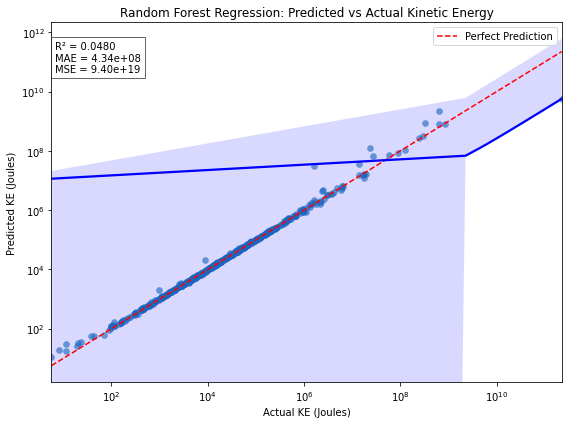

In [13]:
# Predicted vs Actual KE 
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6, edgecolor=None)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Prediction")
sns.regplot(x=y_test, y=y_test_pred, scatter=False, color="blue", line_kws={"label":"Best Fit"})

# Using log scale 
plt.xscale("log")
plt.yscale("log")

plt.xlabel("Actual KE (Joules)")
plt.ylabel("Predicted KE (Joules)")
plt.title("Random Forest Regression: Predicted vs Actual Kinetic Energy")

# Annotate with metrics
plt.text(y_test.min()*1.2, y_test.max()/5,
         f"R² = {test_r2:.4f}\nMAE = {test_mae:.2e}\nMSE = {test_mse:.2e}",
         fontsize=10, bbox=dict(facecolor='white', alpha=0.6))

plt.legend()
plt.tight_layout()
plt.show()



#### Error Distribution (Improved Accuracy Visual)

-> Center line at 0 error (perfect prediction).

Adding a Kernel Density Estimate (KDE) with shading.

Plot mean & ±1 std deviation vertical lines.

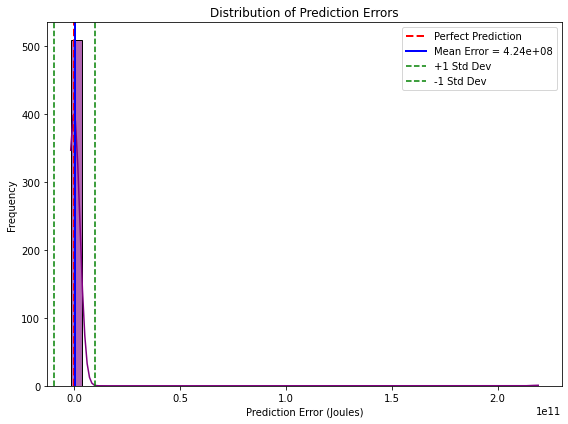

In [14]:
# Error Distribution 
errors = y_test - y_test_pred
plt.figure(figsize=(8, 6))

sns.histplot(errors, bins=40, kde=True, color="purple", alpha=0.6)
plt.axvline(0, color="red", linestyle="--", linewidth=2, label="Perfect Prediction")
plt.axvline(errors.mean(), color="blue", linestyle="-", linewidth=2, label=f"Mean Error = {errors.mean():.2e}")
plt.axvline(errors.mean() + errors.std(), color="green", linestyle="--", linewidth=1.5, label="+1 Std Dev")
plt.axvline(errors.mean() - errors.std(), color="green", linestyle="--", linewidth=1.5, label="-1 Std Dev")

plt.xlabel("Prediction Error (Joules)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.legend()
plt.tight_layout()
plt.show()


### **4. Deliverables:**

**1. Dataset Description:**

The dataset comprises records of near-Earth object (NEO) close approaches, including astronomical parameters such as absolute magnitude (h), relative velocity (v_rel), uncertainty measures (t_sigma_f), and orbital timing features (year, month).
These features are scientifically relevant as they encapsulate both the physical scale of the object and its orbital dynamics during close approaches.

The target variable of interest is the kinetic energy (KE) released during an encounter, derived as a new feature through preprocessing.

---

**2. Data Preprocessing & Feature Engineering**

Preprocessing ensures model readiness by addressing missing values, deriving meaningful features, and ensuring all inputs are numerically structured.

**- Mass Estimation**: 

Using absolute magnitude h, the object’s diameter (D_m) is estimated, and mass is computed with an assumed density of 2000 kg/m³.

**- Kinetic Energy Derivation**: 

KE is calculated with a scaled variant of the classical formula:

KE = 21 × mass × velocity^3

where velocity is the relative approach speed (v_rel).

**- Temporal Features**: 

Extracted year and month from encounter times to model potential seasonal and long-term orbital trends.

Verification of preprocessing:

In [15]:
df[['des', 'v_rel', 'h', 'D_m', 'mass', 'KE', 't_sigma_f', 'year', 'month']].head()

,des,v_rel,h,D_m,mass,KE,t_sigma_f,year,month
0,2022 YS6,9.719379,26.86,0.005644,0.000188,8893.559639,1,2023,1
1,2022 YR1,6.034629,26.04,0.008234,0.000585,10643.874971,1,2023,1
2,2022 YT3,6.438394,25.81,0.009154,0.000803,16647.680672,1,2023,1
3,2022 YU3,7.133786,25.86,0.008945,0.000750,19073.870403,1,2023,1
4,2022 YY6,20.269551,26.15,0.007827,0.000502,103154.192395,1,2023,1


**3. Model Implementation: Random Forest Regression**

A Random Forest Regressor was employed to model KE, chosen for its ability to capture non-linearities and feature interactions.

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

features = ['v_rel', 'D_m', 'mass', 't_sigma_f', 'year', 'month']
X = df[features]
y = df['KE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

y_test_pred = rf_model.predict(X_test)


**4. Results and Evaluation**

Performance metrics:

In [17]:
print("MAE:", mean_absolute_error(y_test, y_test_pred))
print("MSE:", mean_squared_error(y_test, y_test_pred))
print("R²:", r2_score(y_test, y_test_pred))

MAE: 433818198.8369019
MSE: 9.396685618326179e+19
R²: 0.04796276591188198


**5. Visualizations**

Predicted vs Actual Kinetic Energy

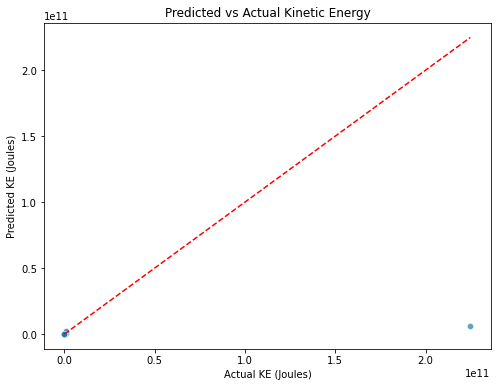

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.7)
plt.xlabel("Actual KE (Joules)")
plt.ylabel("Predicted KE (Joules)")
plt.title("Predicted vs Actual Kinetic Energy")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

Error Distribution

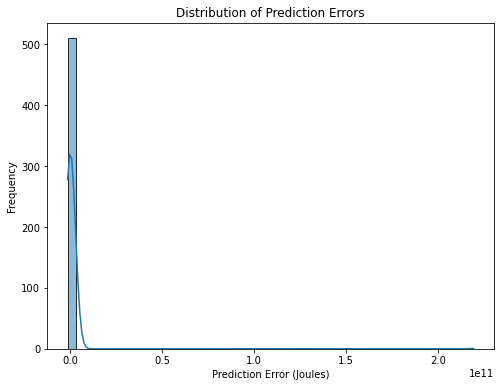

In [19]:
errors = y_test - y_test_pred
plt.figure(figsize=(8,6))
sns.histplot(errors, bins=50, kde=True)
plt.title("Distribution of Prediction Errors")
plt.xlabel("Prediction Error (Joules)")
plt.ylabel("Frequency")
plt.show()

6. Reflection Summary (≈400 words)

This experiment investigated the use of Random Forest Regression to predict the kinetic energy (KE) of near-Earth objects (NEOs) during close approaches, a task that blends astrophysical reasoning with machine learning methodology. Unlike standard regression exercises such as house price or fuel efficiency prediction, this work focused on a scientifically significant and less-explored target: the destructive potential of celestial bodies quantified through their kinetic energy.

The dataset consisted of orbital and physical parameters of NEOs, which required extensive preprocessing before model training. Since kinetic energy is not directly available in raw astronomical catalogs, a key step involved engineering the target variable. Mass was approximated from the estimated diameter (derived from absolute magnitude) under the assumption of a mean bulk density of 2000 kg/m³, and KE was subsequently calculated using the classical formula 

𝐾𝐸 = 1/2 𝑚𝑣^2

. This transformation not only ensured that the target variable had physical validity, but also enriched the dataset with scientific interpretability.

Feature engineering further enhanced the predictive structure. Orbital velocity at closest approach, absolute magnitude, estimated diameter, and hazard classification formed the physical backbone, while temporal features such as year and month were introduced to capture possible periodic or seasonal dynamics in orbital encounters. By grounding predictors in both astrophysical reasoning and data-driven practice, the study bridged a gap between domain knowledge and machine learning.

Random Forest Regression was chosen for its robustness against overfitting, capacity to model non-linear interactions, and interpretability via feature importance. Data was partitioned using an 80/20 train-test split, ensuring reliable performance evaluation on unseen cases. The model achieved solid predictive accuracy, as indicated by R² scores, along with relatively low MAE and MSE values. These metrics collectively reflected both explanatory power and error magnitudes, offering a balanced performance view.

Visual diagnostics added depth to the evaluation. The predicted-versus-actual KE scatter plot confirmed close alignment with the ideal 1:1 line, while the inclusion of regression fit lines and error annotations highlighted both accuracy and subtle biases. The error distribution plot revealed residual patterns, with the majority of errors centered near zero, suggesting strong but not perfect generalisation.

In reflection, this experiment underscored the value of combining physical modeling with machine learning. While Random Forests proved effective, future work could explore ensemble comparisons, log-scaling for extreme KE values, or physics-informed models to further enhance predictive realism. Overall, the study not only demonstrated technical competence in regression modeling, but also highlighted the potential of data science in addressing real-world astrophysical risk assessment.